In [42]:
import glob
import os
import pandas as pd
import re
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import date, timedelta, datetime
%matplotlib inline

In [3]:
def load_registration_data(path = 'data/SOS/processed/voter-registration.csv'):
    df = pd.read_csv(path,header=[0,1],index_col=[0,1])
    dtIdx = pd.DatetimeIndex(df.columns.get_level_values(0))
    col_mIdx = pd.MultiIndex.from_arrays([dtIdx,df.columns.get_level_values(1)])
    df.columns = col_mIdx
    df.sort_index(inplace=True,axis=1,level=[0,1])
    df.sort_index(axis=1,level=[0,1],inplace=True)
    df.sort_index(axis=0,level=[0,1],inplace=True)
    return df

def load_prop_data(path = 'data/SOS/processed/measures.csv'):
    df = pd.read_csv(path,header=[0,1,2],index_col=0)
    dtIdx = pd.DatetimeIndex(df.columns.get_level_values(0))
    col_mIdx = pd.MultiIndex.from_arrays([dtIdx,df.columns.get_level_values(1),df.columns.get_level_values(2)])
    df.columns = col_mIdx
    df.sort_index(inplace=True,axis=1,level=[0,1])
    return df

def load_prop_metadata(path = 'data/SOS/processed/measures_metadata.csv'):
    df = pd.read_csv(path,header=0,index_col=[0,1])
    dtIdx = pd.DatetimeIndex(df.index.get_level_values(0))
    row_mIdx = pd.MultiIndex.from_arrays([dtIdx,df.index.get_level_values(1)])
    df.index = row_mIdx
    df.sort_index(inplace=True,axis=0)
    return df

In [96]:
df_reg = load_registration_data()
df_prop = load_prop_data()
df_prop_meta = load_prop_metadata()

In [17]:
df_reg

Date                      2001-10-02                                     \
Category                   All Other American Independent    Democratic   
County       Count_type                                                   
Alameda      Count        12807.0000           10902.0000  3.777450e+05   
             Fraction         0.0192               0.0163  5.652000e-01   
Alpine       Count           11.0000              25.0000  2.710000e+02   
             Fraction         0.0141               0.0322  3.488000e-01   
Amador       Count          369.0000             515.0000  7.352000e+03   
             Fraction         0.0199               0.0277  3.950000e-01   
Butte        Count         1593.0000            3116.0000  4.104100e+04   
             Fraction         0.0142               0.0278  3.664000e-01   
Calaveras    Count          290.0000             646.0000  9.277000e+03   
             Fraction         0.0116               0.0260  3.738000e-01   
Colusa       Count           51.0000             200.0000  3.044000e+03   
             Fraction         0.0068               0.0266  4.054000e-01   
Contra Costa Count        20252.0000            8349.0000  2.356120e+05   
             Fraction         0.0425               0.0175  4.940000e-01   
Del Norte    Count          164.0000             439.0000  4.889000e+03   
             Fraction         0.0130               0.0348  3.877000e-01   
El Dorado    Count         1147.0000            2336.0000  3.070600e+04   
             Fraction         0.0128               0.0260  3.416000e-01   
Fresno       Count         2391.0000            6419.0000  1.370740e+05   
             Fraction         0.0073               0.0197  4.201000e-01   
Glenn        Count           91.0000             311.0000  4.298000e+03   
             Fraction         0.0079               0.0270  3.725000e-01   
Humboldt     Count          912.0000            1931.0000  3.186000e+04   
             Fraction         0.0120               0.0255  4.205000e-01   
Imperial     Count          656.0000            1066.0000  2.515600e+04   
             Fraction         0.0138               0.0224  5.287000e-01   
Inyo         Count          114.0000             293.0000  3.451000e+03   
             Fraction         0.0113               0.0291  3.429000e-01   
Kern         Count         2441.0000            7765.0000  1.008960e+05   
             Fraction         0.0089               0.0285  3.702000e-01   
...                              ...                  ...           ...   
Shasta       Count          631.0000            2460.0000  2.887100e+04   
             Fraction         0.0075               0.0293  3.438000e-01   
Sierra       Count           41.0000              77.0000  7.960000e+02   
             Fraction         0.0179               0.0335  3.462000e-01   
Siskiyou     Count          254.0000             773.0000  9.835000e+03   
             Fraction         0.0100               0.0307  3.911000e-01   
Solano       Count         2001.0000            3759.0000  9.062900e+04   
             Fraction         0.0112               0.0211  5.091000e-01   
Sonoma       Count         3289.0000            4618.0000  1.207280e+05   
             Fraction         0.0138               0.0193  5.049000e-01   
Stanislaus   Count         3050.0000            4685.0000  8.748200e+04   
             Fraction         0.0148               0.0227  4.234000e-01   
State Total  Count       256528.0000          310839.0000  6.940276e+06   
             Fraction         0.0167               0.0203  4.525000e-01   
Sutter       Count         1334.0000             847.0000  1.289100e+04   
             Fraction         0.0365               0.0232  3.529000e-01   
Tehama       Count          341.0000             974.0000  1.048100e+04   
             Fraction         0.0127               0.0363  3.908000e-01   
Trinity      Count          166.0000             237.0000  2.920000e+03   
             Fraction    

In [51]:
df_prop

Date                2002-03-05                                   \
Proposition     Proposition_40          Proposition_41            
Votes                       No      Yes             No      Yes   
Alameda                  74228   142873          81464   130697   
Alpine                     256      281            296      233   
Amador                    5883     3605           5888     3573   
Butte                    25178    21833          24582    24682   
Calaveras                 7642     4923           7642     4763   
Colusa                    2931     1322           2679     1518   
Contra Costa             74344   103748          79849    95390   
Del Norte                 3625     1903           3419     2052   
El Dorado                24884    16872          25075    16173   
Fresno                   53206    53571          50762    54034   
Glenn                     3706     1155           3225     1579   
Humboldt                 16576    15093          16216    14875   
Imperial                  7478     9210           8560     7768   
Inyo                      3297     2217           3100     2305   
Kern                     50046    37754          57589    43359   
Kings                     8046     5821           7932     5755   
Lake                      5881     5372           6102     4988   
Lassen                    5065     2351           4622     2766   
Los Angeles             347804   633273         414154   536127   
Madera                   12143     6565          11473     7068   
Marin                    19960    42222          22778    38257   
Mariposa                  3389     2041           3356     2009   
Mendocino                 7298     8709           9841     9232   
Merced                   14019    12509          14501    12094   
Modoc                     2416      735           2085     1028   
Mono                      1336     1048           1330     1034   
Monterey                 24857    34555          29173    28865   
Napa                     11144    15315          11884    14062   
Nevada                   17307    12884          17329    12199   
Orange                  216770   270153         264208   208619   
Placer                   39972    28446          40883    26942   
Plumas                    4592     2375           4050     2855   
Riverside                79428    96961          85048    94644   
Sacramento               99742   111800         110100    99983   
San Benito                4304     4767           4601     4277   
San Bernardino           79307    84686          83797    77362   
San Diego               191832   233412         209148   207088   
San Francisco            31184   111530          37935   101611   
San Joaquin              43571    43405          45385    40223   
San Luis Obispo          29788    26212          30345    24732   
San Mateo                40094    73921          43941    67588   
Santa Barbara            35037    35126          35937    33007   
Santa Clara              90006   141914         101621   126060   
Santa Cruz               18756    36009          25112    33665   
Shasta                   25445    11588          23512    12911   
Sierra                     973      473            950      478   
Siskiyou                  9035     3285           7978     4265   
Solano                   27106    31100          28281    28615   
Sonoma                   43125    67883          48284    60858   
Stanislaus               34362    35358          37444    31053   
Sutter                    8786     4216           8617     4287   
Tehama                    9124     4601           8764     4806   
Trinity                   3037     1392           2805     1565   
Tulare                   27644    16515          25599    18949   
Tuolumne                  7673     5852           7539     5717   
Ventura                  53433    69671          60585    60059   
Yolo                     14358    20185        

In [55]:
df_prop_meta

Description  \
Date       Proposition                                                          
2002-03-05 Proposition_40       Clean Water/Air, Safe Parks, Coast Protection   
           Proposition_41               Voting Modernization Bond Act of 2002   
           Proposition_42      Transportation Funding: Sales/Use Tax Revenues   
           Proposition_43                          Right to have vote counted   
           Proposition_44                                     Insurance Fraud   
           Proposition_45     Legislative Term Limits. Local Voter Petitions.   
2002-11-05 Proposition_46            Housing and Emergency Shelter Trust Fund   
           Proposition_47             Kindergarten-University Facilities Bond   
           Proposition_48                                 Court Consolidation   
           Proposition_49                 After School Programs. State Grants   
           Proposition_50     Water Quality, Supply/Safe Drinking Water Bonds   
           Proposition_51   Transportation. Allocation of Motor Vehicle Taxes   
           Proposition_52                     Election Day Voter Registration   
2003-10-07 Proposition_53                             Infrastructure: Finance   
           Proposition_54         Classification by Race, ... Color or Origin   
2004-03-02 Proposition_55                                      Education Bond   
           Proposition_56                                        State Budget   
           Proposition_57                              Economic Recovery Bond   
           Proposition_58                                     Balanced Budget   
2004-11-02 Proposition_1A             Protection of Local Government Revenues   
           Proposition_59                       Public Records, Open Meetings   
           Proposition_60                Election Rights of Political Parties   
           Proposition_60A                                  Surplus Property.   
           Proposition_61        Children's Hospital Projects. Grant Program.   
           Proposition_62                                Elections. Primaries   
           Proposition_63                   Mental Health Services Expansion.   
           Proposition_64      Limits on Private Enforcement of Business Laws   
           Proposition_65    Local Government Funds, Revenues. State Mandates   
           Proposition_66                  Limitations on "Three Strikes" Law   
           Proposition_67                Emergency Medical Services. Funding.   
...                                                                       ...   
2012-11-06 Proposition_37               Genetically Engineered Foods Labeling   
           Proposition_38         Tax for Education. Early Childhood Programs   
           Proposition_39                     Business Tax for Energy Funding   
           Proposition_40                         Redistricting State\nSenate   
2014-06-03 Proposition_41      Veterans Housing\n& Homeless\nBond Act of 2014   
           Proposition_42    Public Records.\nOpen Meetings.\nReimbursements.   
2014-11-04 Proposition_1    Funding Water Quality, \nSupply, Treatment,\n ...   
           Proposition_2                  State Budget\nStabilization Account   
           Proposition_45                 Healthcare\nInsurance Rate\nChanges   
           Proposition_46           Doctor Drug Testing,\nMedical\nNegligence   
           Proposition_47         Criminal Sentences,\nMisdemeanor\nPenalties   
           Proposition_48                   Indian Gaming Compacts Referendum   
2016-06-07 Proposition_50                        Suspension \nof Legislators.   
2016-11-08 Proposition_51               K-12 and Community College Facilities   
           Proposition_52                       Medi-Cal Hospital Fee Program   
           Proposition_53                   Voter Approval of \nRevenue Bonds   
           Proposition_54                  Legislative Procedure Requirements   
           Propo

Date
2001-10-02    0.717900
2002-01-04    0.710300
2002-02-04    0.708700
2002-02-19    0.710500
2002-10-07    0.707100
2002-10-21    0.712900
2003-02-10    0.702600
2003-08-08    0.688400
2003-09-22    0.704500
2003-09-30    0.706800
2004-01-02    0.684200
2004-02-17    0.689500
2004-09-03    0.709100
2004-10-18    0.750000
2005-02-10    0.739200
2005-09-09    0.705600
2005-10-24    0.706700
2006-01-03    0.701100
2006-04-07    0.688000
2006-05-22    0.695100
2006-09-08    0.690300
2006-10-23    0.701100
2007-02-10    0.688800
2007-09-04    0.677700
2007-12-07    0.672900
2008-01-01    0.677700
2008-01-22    0.684700
2008-04-04    0.691100
2008-05-19    0.700000
2008-09-05    0.697900
2008-10-20    0.745600
2009-02-10    0.743900
2009-03-20    0.737900
2009-05-04    0.733500
2010-01-05    0.726100
2010-04-09    0.721200
2010-05-24    0.723900
2010-09-03    0.722400
2010-10-18    0.734000
2011-02-10    0.728100
2012-01-03    0.720140
2012-04-06    0.718700
2012-05-21    0.723400
2012-0

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


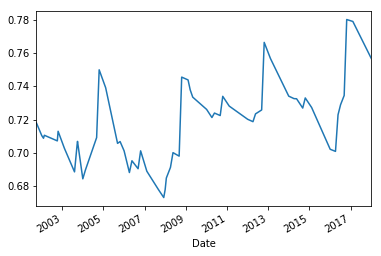

In [56]:
#df_reg.query('County == "State Total" & Count_type == "Fraction" & Category == "Total Registered"')
idx = pd.IndexSlice
reg_vs_time = df_reg.loc[idx['State Total','Fraction'],idx[:,'Total Registered']]
reg_vs_time.index = reg_vs_time.index.droplevel(level='Category')
print(reg_vs_time)
reg_vs_time.plot()

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


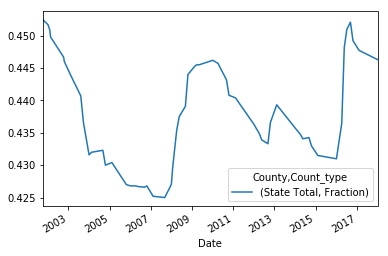

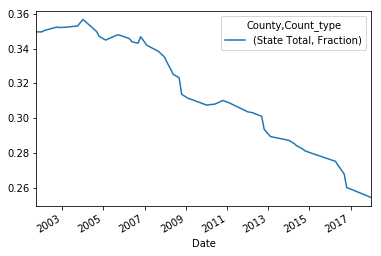

In [40]:
res = df_reg.xs(('State Total','Fraction'),level=('County','Count_type')).xs('Democratic',level='Category',axis=1)
res.T.plot()
res = df_reg.xs(('State Total','Fraction'),level=('County','Count_type')).xs('Republican',level='Category',axis=1)
res.T.plot()

In [59]:
df_reg.loc[idx[county,'Count'],idx[:,'Eligible']]

Date        Category
2001-10-02  Eligible    573692.0
2002-01-04  Eligible    575895.0
2002-02-04  Eligible    576624.0
2002-02-19  Eligible    576971.0
2002-10-07  Eligible    574401.0
2002-10-21  Eligible    574619.0
2003-02-10  Eligible    576427.0
2003-08-08  Eligible    579267.0
2003-09-22  Eligible    580024.0
2003-09-30  Eligible    580149.0
2004-01-02  Eligible    570617.0
2004-02-17  Eligible    570808.0
2004-09-03  Eligible    571226.0
2004-10-18  Eligible    571538.0
2005-02-10  Eligible    574413.0
2005-09-09  Eligible    577544.0
2005-10-24  Eligible    578065.0
2006-01-03  Eligible    578851.0
2006-04-07  Eligible    579946.0
2006-05-22  Eligible    575791.0
2006-09-08  Eligible    576994.0
2006-10-23  Eligible    578851.0
2007-02-10  Eligible    579885.0
2007-09-04  Eligible    585617.0
2007-12-07  Eligible    587186.0
2008-01-01  Eligible    591671.0
2008-01-22  Eligible    592185.0
2008-04-04  Eligible    593701.0
2008-05-19  Eligible    594741.0
2008-09-05  Eligible  

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


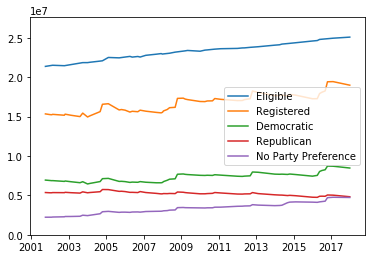

In [66]:
idx = pd.IndexSlice
county = 'State Total'
elg_vs_time = df_reg.loc[idx[county,'Count'],idx[:,'Eligible']]
reg_vs_time = df_reg.loc[idx[county,'Count'],idx[:,'Total Registered']]
dem_vs_time = df_reg.loc[idx[county,'Count'],idx[:,'Democratic']]
rep_vs_time = df_reg.loc[idx[county,'Count'],idx[:,'Republican']]
grn_vs_time = df_reg.loc[idx[county,'Count'],idx[:,'Green']]
npp_vs_time = df_reg.loc[idx[county,'Count'],idx[:,'No Party Preference']]
x = elg_vs_time.index.get_level_values('Date')
y = elg_vs_time.values
plt.plot(x,y,label='Eligible')
y = reg_vs_time.values
plt.plot(x,y,label='Registered')
y = dem_vs_time.values
plt.plot(x,y,label='Democratic')
y = rep_vs_time.values
plt.plot(x,y,label='Republican')
# y = grn_vs_time.values
# plt.plot(x,y,label='Green')
y = npp_vs_time.values
plt.plot(x,y,label='No Party Preference')
plt.ylim(0,1.1*max(elg_vs_time.values))
plt.legend()

In [98]:
df_reg_frac = df_reg.loc[idx[:,'Fraction'],idx[:,'Total Registered']]
df_reg_frac.index = df_reg_frac.index.droplevel('Count_type')
df_reg_frac.columns = df_reg_frac.columns.droplevel('Category')

df_reg_frac.loc['Lake'][df_reg_frac.loc['Lake']>1]

Date
2008-04-04    4.1317
Name: Lake, dtype: float64

In [99]:
print(df_reg.loc[idx['Lake','Fraction'],idx['2008-04-04','Total Registered']])
print(df_reg.loc[idx['Lake','Count'],idx['2008','Eligible']])

Date        Category        
2008-04-04  Total Registered    4.1317
Name: (Lake, Fraction), dtype: float64
Date        Category
2008-01-01  Eligible    46454.0
2008-01-22  Eligible    46478.0
2008-04-04  Eligible     8024.0
2008-05-19  Eligible    46500.0
2008-09-05  Eligible    46714.0
2008-10-20  Eligible    46758.0
Name: (Lake, Count), dtype: float64


In [100]:
df_reg.loc[idx['Lake','Count'],idx['2008-04-04','Eligible']] = 46490
df_reg.loc[idx['Lake','Fraction'],idx['2008-04-04','Total Registered']] = (
    df_reg.loc[idx['Lake','Count'],idx['2008-04-04','Total Registered']].values / df_reg.loc[idx['Lake','Count'],idx['2008-04-04','Eligible']].values)

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


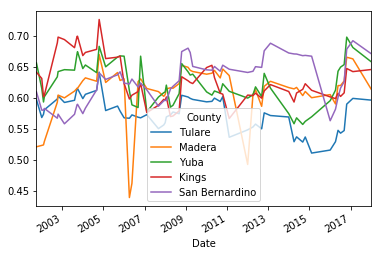

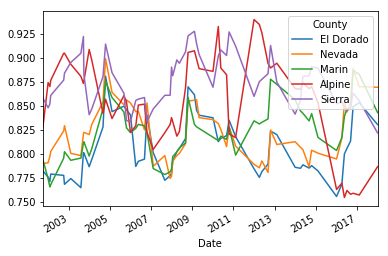

In [124]:
df_reg_frac = df_reg.loc[idx[:,'Fraction'],idx[:,'Total Registered']]
df_reg_frac.index = df_reg_frac.index.droplevel('Count_type')
df_reg_frac.columns = df_reg_frac.columns.droplevel('Category')
df_reg_frac = df_reg_frac.T
state_total = df_reg_frac.pop('State Total')
counties_sorted_mean_reg = df_reg_frac.mean().sort_values().index
# bottom 5 registration rates
df_reg_frac[counties_sorted_mean_reg[:5]].plot()
# top 5 registration rates
df_reg_frac[counties_sorted_mean_reg[-5:]].plot()